## Problem 1b: 
## Fixed flux spinodal decomposition on a square domain

Necessary imports for graphing and PDE solving:

In [12]:
%matplotlib inline
import fipy as fp
import numpy as np
import sympy
import matplotlib.pyplot as plt

The square domain of the problem has dimensions 20 units by 20 units, with cells that are half a unit long on each side. A Grid2D object is used because the domain's boundary conditions are fixed (no flux).

In [13]:
mesh = fp.Grid2D(nx=50, ny=50, dx=0.5, dy=0.5)

Constants and initial conditions:
$c_{\alpha}, c_{\beta},$ and $c_m = \frac{(c_{\alpha} + c_{\beta})}{2}$ are concentrations at which the bulk free energy has minima.
$\kappa$ is the gradient energy coefficient.

In [14]:
c_alpha = 0.05
c_beta = 0.95
c_m = (c_alpha + c_beta) / 2.
# control on height of double-well barrier
A = 2.0
kappa = 2.0

B = A / (c_alpha - c_m)**2
D = D_alpha = D_beta = 2. / (c_beta - c_alpha)

# initial conditions
c_0 = 0.45
q = np.sqrt((2., 3.))
epsilon = 0.01

$c_{var}$ is a cell variable specifying concentrations at various points in the mesh. Here, it is the solution variable:

$c_{var}\left(\vec{r}, t\right)$ such that

$$ c_{var}\left(\vec{r}, 0\right) = \bar{c}_0 + \epsilon \cos \left( \vec{q} \cdot \vec{r} \right) $$

In [15]:
# array of sample c-values: used in f versus c plot
vals = np.linspace(-.1, 1.1, 1000)

# setting up the concentration field
c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)
r = np.array((mesh.x, mesh.y))
c_var[:] = c_0 + epsilon * np.cos((q[:, None] * r).sum(0))

# viewer = fp.Viewer(c_var, limits = {'ymin': 0, 'ymax': 20},
#                     datamin=.440, datamax =.460,
#                     title = "Matplot2DViewer test")

The equation for the bulk free energy density (alternatively called the chemical free energy density) of this system is expressed as 
$$ \int\limits_V{\!\Big(f_{chem}+\frac{\kappa}{2}{\big|\nabla c\big|}^2}\Big)\,\mathrm{d}V.$$ Also, $f_{chem}$ or $f_0$ in this problem has a simple polynomial form, $$ f_0  = -\frac{A}{2}(c-c_m)^2 +\frac{B}{4}(c-c_m)^4 + \frac{c_{\alpha}}{4}(c-c_{\alpha})^4 + \frac{c_{\beta}}{4}(c-c_{\beta})^4.$$

In [16]:
# bulk free energy density
def f_0(c):
    return - A / 2 * (c - c_m)**2 + B / 4 * (c - c_m)**4+ c_alpha / 4 * (c - c_alpha)**4 + c_beta / 4 * (c - c_beta)**4
def f_0_var(c_var):
    return -A + 3*B*(c_var - c_m)**2 + 3*c_alpha*(c_var - c_alpha)**2 + 3*c_beta*(c_var - c_beta)**2
    #return sympy.diff(f_0(c), c, 2)
# free energy
def f(c):
    return (f_0(c)+ .5*kappa*(c.grad.mag)**2)

# plot free energy density versus c
def plotf_c():
    plt.figure(1)
    plt.xlabel('c')
    plt.ylabel('f_0')
    plt.plot(vals, f_0(vals))
    plt.show()


Here, the elapsed time and total free energy at each time step are saved to separate lists. These lists are then updated in a text file.

In [17]:
# save elapsed time and free energy at each data point
f_data = []
time_data = []

def save_data(f, time):
    f_data.append(f.value)
    time_data.append(time)
    np.savetxt('1bfree_energy.txt', zip(time_data, f_data))

The solver equation is now defined.

In [18]:
# start solver
eqn = fp.TransientTerm(coeff=1.) == fp.DiffusionTerm(D * f_0_var(c_var)) - fp.DiffusionTerm((D, kappa))

A time stepping scheme is used to solve the equation. If the residual increases, the solver backtracks; if the specified tolerance is not reached, the time step is recalculated.

In [19]:
elapsed = 0.0
steps = 0
dt = 0.01
total_sweeps = 2
tolerance = 1e-1
total_steps = 2000

In [20]:
c_var.updateOld()
from fipy.solvers.pysparse import LinearLUSolver as Solver
solver = Solver()

Initialize an empty list for generated viewers:

In [21]:
viewers = []

In [22]:
# viewers.append(fp.Viewer((fp.dump.read('{0}{1}{2}'.format("1b", steps, ".pkl"))['var']),
#                         limits = {'ymin': 0.0, 'ymax': 20.0},
#                         datamin=.2, datamax =.8,
#                         title = '{0}{1}'.format("Time Step ", steps)))

In [23]:
while steps < total_steps:
    res0 = eqn.sweep(c_var, dt=dt, solver=solver)

    for sweeps in range(total_sweeps):
        res = eqn.sweep(c_var, dt=dt, solver=solver)

#         print ' '
#         print 'steps',steps
#         print 'res',res
#         print 'sweeps',sweeps
#         print 'dt',dt


    if res < res0 * tolerance:
        steps += 1
        elapsed += dt
        dt *= 1.1
        
        if (steps%(total_steps/100)==0):
            print steps
            print elapsed
            # record the volume integral of the free energy 
            save_data(f(c_var).cellVolumeAverage*mesh.numberOfCells, elapsed)
            # pickle the data on c as a function of space at this particular time
            fp.dump.write({'time' : elapsed, 'var': c_var}, '1bpickles/{0}.pkl'.format("1b", steps, ".pkl"))
            # create a viewer based on the pickled data
            
        c_var.updateOld()
    else:
        dt *= 0.8
        c_var[:] = c_var.old

20
0.572749994933
40
4.42592555682
60
16.5993580076
80
22.0906458956
100
26.0630126019
120
29.6856810577
140
33.0683938547
160
36.2256311833
180
39.3767763433
200
42.3526554334
220
45.2580692682
240
48.224252062
260
51.5362717525
280
55.1496416016
300
58.4488104529
320
62.1851814455
340
66.0310821724
360
69.7079043013
380
73.7336878071
400
76.5981976704
420
79.2405801752
440
81.8487603055
460
84.4532407345
480
87.0819955871
500
89.7363461712
520
92.3855749512
540
95.0015712471
560
97.6129500975
580
100.191058494
600
102.76505535
620
105.305734999
640
107.842810697
660
110.374990882
680
112.932168788
700
115.512834735
720
118.061128265
740
120.604923851
760
123.116310032
780
125.62369108
800
128.154918603
820
130.710310563
840
133.232626134
860
135.751363803
880
138.265241345
900
140.747584276
920
143.309597124
940
145.839471543
960
148.364880528
980
150.858114365
1000
153.347372018
1020
155.832324974
1040
158.369246516
1060
160.873330745
1080
163.373862932
1100
165.869570122
1120
168.3

In [24]:
fp.MultiViewer(viewers).plot()

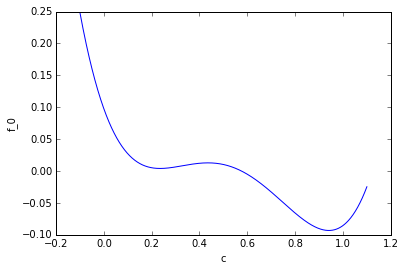

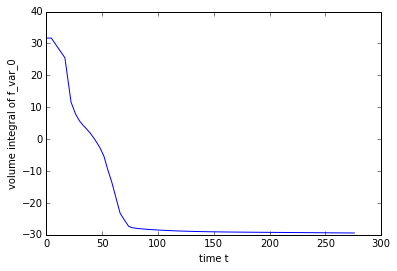

In [25]:
plotf_c()

plt.figure(3)
plt.xlabel('time t')
plt.ylabel('volume integral of f_var_0')
plt.plot(time_data, f_data)
plt.show()

In [ ]:
print time_data